In [43]:
import pandas as pd
import sklearn.cluster
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('data/Test_Data_1102_enumerated.csv')

## Kmeans Clustering

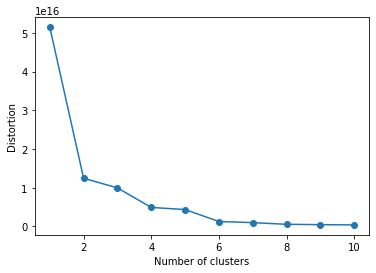

In [ ]:
# Convert DataFrame to matrix
mat = df.values
mat[mat == np.nan] = -1
mat = mat.astype('int')

#how many clusters? 
distortions = []
for i in range(1, 11):
    km = sklearn.cluster.KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(mat)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [113]:
# Using sklearn
km = sklearn.cluster.KMeans(n_clusters=6)
km.fit(mat)
# Get cluster assignment labels
labels = km.labels_
# Format results as a DataFrame
results = pd.DataFrame([df.index,labels], ["index", "label"]).T
results

,index,label
0,0,5
1,1,5
2,2,5
3,3,5
4,4,5
...,...,...
25484,25484,1
25485,25485,1
25486,25486,1
25487,25487,1


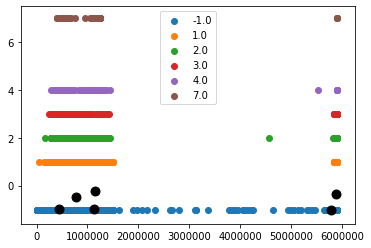

In [130]:
##TODO: plot, figure out important features of clustering

#Getting the Centroids
centroids = km.cluster_centers_

featureX = 'RedCapID'
featureXInd = 0
featureY = 'methoddeath'
featureYInd = 13
u_labels = np.unique(df[featureY]) 

#plotting the results:
for i in u_labels:
    x = df.loc[df[featureY] == i, featureX] #df.loc[df[feature] == i].index
    y = df.loc[df[featureY] == i, featureY]
    plt.scatter(x, y, label=i)
plt.scatter(centroids[:,featureXInd] , centroids[:,featureYInd] , s = 80, color = 'k')
plt.legend()
plt.show()

## Hierarchical Clustering

In [73]:
# https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/

from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
cluster.fit_predict(mat)

array([0, 0, 0, ..., 4, 4, 4], dtype=int64)

### Working on some visualizations of the clustering